# Kucing atau Anjing?

terinspirasi dari: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

In [ ]:
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
from fastcore.all import *
import logging
import time
from fastai.vision.all import *

membuat fungsi untuk mendownload gambar melalui Google

In [49]:
def search_images(keyword, image_dir, size="medium", max_images=200):
    google_crawler = GoogleImageCrawler(storage={'root_dir': image_dir})
    logging.disable(logging.CRITICAL)
    flts = dict(size=size)
    google_crawler.crawl(keyword=keyword, filters=flts, max_num=max_images)
    return sorted(list(image_dir.glob("*")))

diuji coba, ternyata muncul gambar kucing.

In [47]:
pth_cat = Path("cat")
cat_locs = search_images("cat", pth_cat, max_images=1); cat_locs

[Path('cat/000001.jpg')]

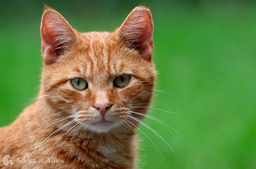

In [48]:
im = Image.open(cat_locs[0])
im.to_thumb(256, 256)

lakukan hal yang sama tetapi untuk anjing

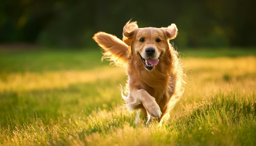

In [50]:
pth_dog = Path("dog")
dog_locs = search_images("dog", pth_dog, max_images=1)

im = Image.open(dog_locs[0])
im.to_thumb(256, 256)

oke, selanjutnya membuat folder untuk mengumpulkan gambar dan anjing. Gambar-gambar ini akan digunakan untuk training dan validasi

In [97]:
def search_images_parallel(keyword, image_dir, size="medium", max_images=200):
    google_crawler = BingImageCrawler(
        feeder_threads=1,
        parser_threads=2,
        downloader_threads=4,
        storage={'root_dir': image_dir})
    logging.disable(logging.CRITICAL)
    flts = dict(size=size, type="photo")
    google_crawler.crawl(keyword=keyword, filters=flts, max_num=max_images)
    return sorted(list(image_dir.glob("*")))

In [98]:
searches = 'cat','dog'
path = Path('cat_or_not')

for o in searches:
    dest = (path/o)
    search_images_parallel(f"{o} photos", dest)
    time.sleep(5)
    resize_images(dest, max_size=400, dest=dest)

kita gunakan fastai untuk cek data, training, dan prediksi

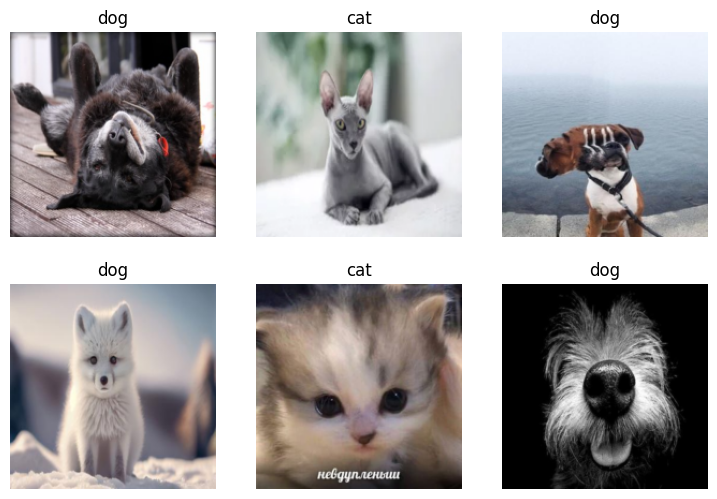

In [100]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [101]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/yudhastyawan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:38<00:00, 1.22MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.077830,0.469250,0.160000,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.358905,0.189952,0.060000,00:06
1,0.251838,0.248030,0.100000,00:04
2,0.213601,0.298915,0.120000,00:04


In [104]:
is_cat,_,probs = learn.predict(cat_locs[0])
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 0.9998


In [105]:
is_cat,_,probs = learn.predict(dog_locs[0])
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: dog.
Probability it's a cat: 0.0000


berhasil mendeteksi kucing dan anjing!